In [3]:
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd

In [35]:
filename = r'myj.TIF'
dataset = gdal.Open(filename)
im_width = dataset.RasterXSize
im_height = dataset.RasterYSize
im_bands = dataset.RasterCount
extent = dataset.GetGeoTransform()
var = dataset.GetProjection()
for i in range(1, im_bands + 1):
    band = dataset.GetRasterBand(i)
    band_name = band.GetDescription()
    print(f'Band {i}: {band_name}')

Band 1: Band_1
Band 2: Band_2
Band 3: Band_3
Band 4: Band_4
Band 5: Band_5


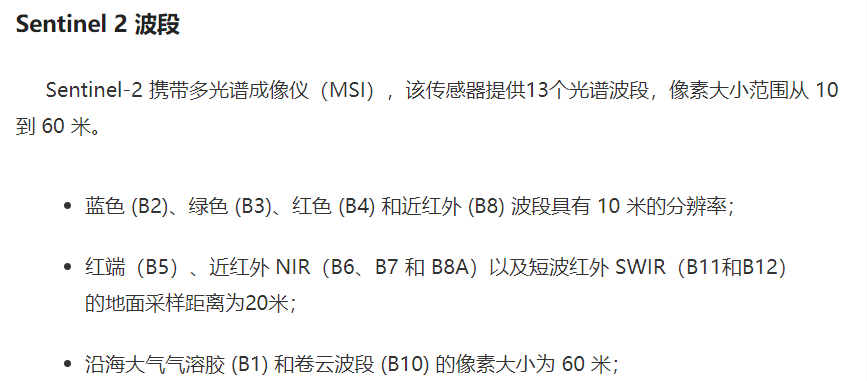

In [36]:
def band_func(dataset,i):
    num=2
    temp=dataset.GetRasterBand(i).ReadAsArray()[num:-num,num:-num]
    temp[temp==65535]=0
    temp=temp/temp.max()
    return temp

In [37]:
red_band=band_func(dataset,3)
green_band=band_func(dataset,2)
blue_band=band_func(dataset,1)
nir_band=band_func(dataset,4)
flag_band=band_func(dataset,5)

In [38]:
def find_nan_positions(matrix):
    if not np.isnan(matrix).any():
        return False
    else:
        rows, cols = np.where(np.isnan(matrix))
        nan_positions = list(zip(rows, cols))
        return nan_positions

result = find_nan_positions(feature_index)
print(result) 

NameError: name 'feature_index' is not defined

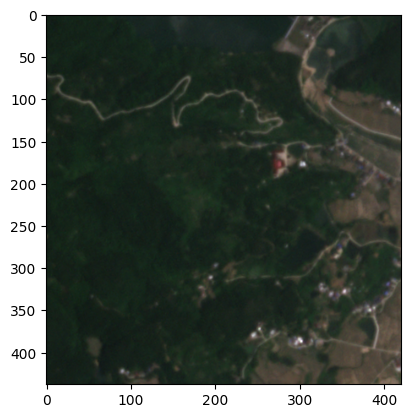

In [39]:
rgb_image = np.dstack((red_band, green_band, blue_band))
rgb_image=rgb_image

plt.imshow(rgb_image)
plt.show()

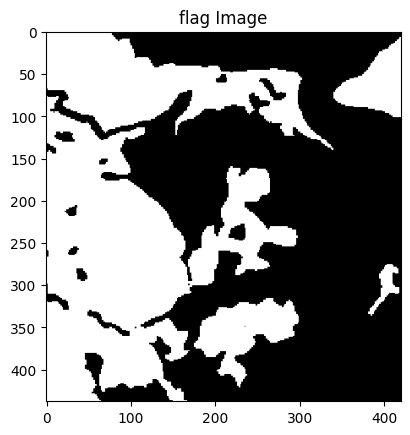

In [40]:
plt.imshow(flag_band,cmap='gray')
plt.title('flag Image')
plt.show()

In [41]:
#指数计算
ndvi = (nir_band - red_band) / (nir_band + red_band)
rvi = nir_band / red_band
dvi = nir_band - red_band
exg = 2 * nir_band - red_band - blue_band
vdvi = ( 2 * green_band - red_band - blue_band ) / ( 2 * green_band + red_band + blue_band )
ngbdi = ( green_band - blue_band ) / ( green_band + blue_band )
ngrdi = ( green_band - red_band ) / ( green_band + red_band )

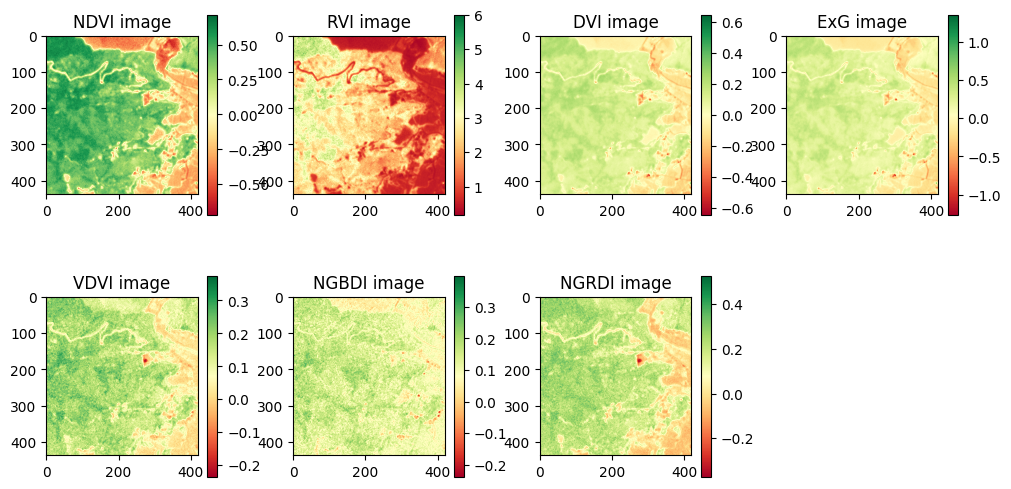

In [42]:
# 创建一个包含两行三列的子图网格
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.3, hspace=0.3)

im1 = axs[0, 0].imshow(ndvi, cmap='RdYlGn')
axs[0, 0].set_title('NDVI image')
plt.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(rvi, cmap='RdYlGn')
axs[0, 1].set_title('RVI image')
plt.colorbar(im2, ax=axs[0, 1])

im3 = axs[0, 2].imshow(dvi, cmap='RdYlGn')
axs[0, 2].set_title('DVI image')
plt.colorbar(im3, ax=axs[0, 2])

im4 = axs[0, 3].imshow(exg, cmap='RdYlGn')
axs[0, 3].set_title('ExG image')
plt.colorbar(im4, ax=axs[0, 3])

im5 = axs[1, 0].imshow(vdvi, cmap='RdYlGn')
axs[1, 0].set_title('VDVI image')
plt.colorbar(im5, ax=axs[1, 0])

im6 = axs[1, 1].imshow(ngbdi, cmap='RdYlGn')
axs[1, 1].set_title('NGBDI image')
plt.colorbar(im6, ax=axs[1, 1])

im7 = axs[1, 2].imshow(ngrdi, cmap='RdYlGn')
axs[1, 2].set_title('NGRDI image')
plt.colorbar(im7, ax=axs[1, 2])

# 隐藏最后一个子图
axs[1, 3].axis('off')

# 显示图形
plt.show()

In [44]:
#纹理计算
def texture(input,window_size=3,levels=64):
    
    input_2=(input*(levels-1)).astype(int)
    # 计算输入矩阵的行列数
    rows, cols = input.shape
    
    # 创建一个新的矩阵来存储纹理特征
    energy = np.zeros((rows, cols))
    correlation = np.zeros((rows, cols))
    contrast = np.zeros((rows, cols))
    homogeneity = np.zeros((rows, cols))
    
    # 遍历每个像素点
    for i in range(rows):
        if i%10==0:
            print(i/rows)
        for j in range(cols):
            # 确定当前窗口的范围
            row_start = max(0, i - window_size // 2)
            row_end = min(rows, i + window_size // 2 + 1)
            col_start = max(0, j - window_size // 2)
            col_end = min(cols, j + window_size // 2 + 1)
            
            # 提取当前窗口内的图像块
            image_block = input_2[row_start:row_end, col_start:col_end]
            # 计算当前窗口内图像块的灰度共生矩阵
            glcm = graycomatrix(image_block, distances=[1], angles=[0], levels=levels, symmetric=True, normed=True)
            
            
            
            # 提取能量（energy）作为纹理特征
            energy[i, j] = graycoprops(glcm, 'energy')[0, 0]
            correlation[i, j] = graycoprops(glcm, 'correlation')[0, 0]
            contrast[i, j] = graycoprops(glcm, 'contrast')[0, 0]
            homogeneity[i, j] = graycoprops(glcm, 'homogeneity')[0, 0]
    return [energy,correlation,contrast,homogeneity]

In [45]:
from multiprocessing.pool import ThreadPool as Pool

PROCESSES=4
with Pool(PROCESSES) as pool:
    pramas=[(red_band, ),(green_band, ),(blue_band, ),(nir_band, )]
    results=[pool.apply_async(texture,p) for p in pramas]
    
    for r in results:
        print('\t', r.get())

0.0
0.0
0.0
0.0
0.0228310502283105
0.0228310502283105
0.0228310502283105
0.0228310502283105
0.045662100456621
0.045662100456621
0.045662100456621
0.045662100456621
0.0684931506849315
0.0684931506849315
0.0684931506849315
0.0684931506849315
0.091324200913242
0.091324200913242
0.091324200913242
0.091324200913242
0.1141552511415525
0.1141552511415525
0.1141552511415525
0.1141552511415525
0.136986301369863
0.136986301369863
0.136986301369863
0.136986301369863
0.1598173515981735
0.1598173515981735
0.1598173515981735
0.1598173515981735
0.182648401826484
0.182648401826484
0.182648401826484
0.182648401826484
0.2054794520547945
0.2054794520547945
0.2054794520547945
0.2054794520547945
0.228310502283105
0.228310502283105
0.228310502283105
0.228310502283105
0.2511415525114155
0.2511415525114155
0.2511415525114155
0.2511415525114155
0.273972602739726
0.273972602739726
0.273972602739726
0.273972602739726
0.2968036529680365
0.2968036529680365
0.2968036529680365
0.2968036529680365
0.319634703196347
0.

	 [array([[0.5       , 0.35355339, 0.39528471, ..., 0.58630197, 0.39528471,
        0.5       ],
       [0.40824829, 0.33333333, 0.44095855, ..., 0.5527708 , 0.372678  ,
        0.47140452],
       [0.52704628, 0.33333333, 0.44095855, ..., 0.5527708 , 0.42491829,
        0.52704628],
       ...,
       [0.52704628, 0.56519417, 0.61237244, ..., 0.68718427, 0.39086798,
        0.52704628],
       [0.47140452, 0.45643546, 0.61237244, ..., 0.56519417, 0.40824829,
        0.47140452],
       [0.61237244, 0.5       , 0.61237244, ..., 0.55901699, 0.46770717,
        0.5       ]]), array([[ 0.        ,  0.11111111, -0.09090909, ...,  0.46666667,
        -0.09090909, -0.81818182],
       [-0.5       ,  0.05263158, -0.12      , ...,  0.45454545,
        -0.01204819, -0.76470588],
       [-0.8       ,  0.05263158, -0.01204819, ...,  0.45454545,
         0.1       , -0.2       ],
       ...,
       [-0.8       , -0.28571429, -0.33333333, ..., -0.17647059,
         0.2173913 ,  0.64705882],
       

In [46]:
np.save('texture_myj/red_energy', results[0].get()[0])
np.save('texture_myj/red_correlation', results[0].get()[1])
np.save('texture_myj/red_contrast', results[0].get()[2])
np.save('texture_myj/red_homogeneity', results[0].get()[3])
np.save('texture_myj/green_energy', results[1].get()[0])
np.save('texture_myj/green_correlation', results[1].get()[1])
np.save('texture_myj/green_contrast', results[1].get()[2])
np.save('texture_myj/green_homogeneity', results[1].get()[3])
np.save('texture_myj/blue_energy', results[2].get()[0])
np.save('texture_myj/blue_correlation', results[2].get()[1])
np.save('texture_myj/blue_contrast', results[2].get()[2])
np.save('texture_myj/blue_homogeneity', results[2].get()[3])
np.save('texture_myj/nir_energy', results[3].get()[0])
np.save('texture_myj/nir_correlation', results[3].get()[1])
np.save('texture_myj/nir_contrast', results[3].get()[2])
np.save('texture_myj/nir_homogeneity', results[3].get()[3])

In [47]:
files = glob.glob("texture_myj/*")
print("包括以下纹理变量：")
i=0
for file in files:
  print(file[12:-4])
  vars()[file[12:-4]]=np.load(file)
  i=i+1
print("共计"+str(i)+"个纹理变量")

包括以下纹理变量：
blue_contrast
blue_correlation
blue_energy
blue_homogeneity
green_contrast
green_correlation
green_energy
green_homogeneity
nir_contrast
nir_correlation
nir_energy
nir_homogeneity
red_contrast
red_correlation
red_energy
red_homogeneity
共计16个纹理变量


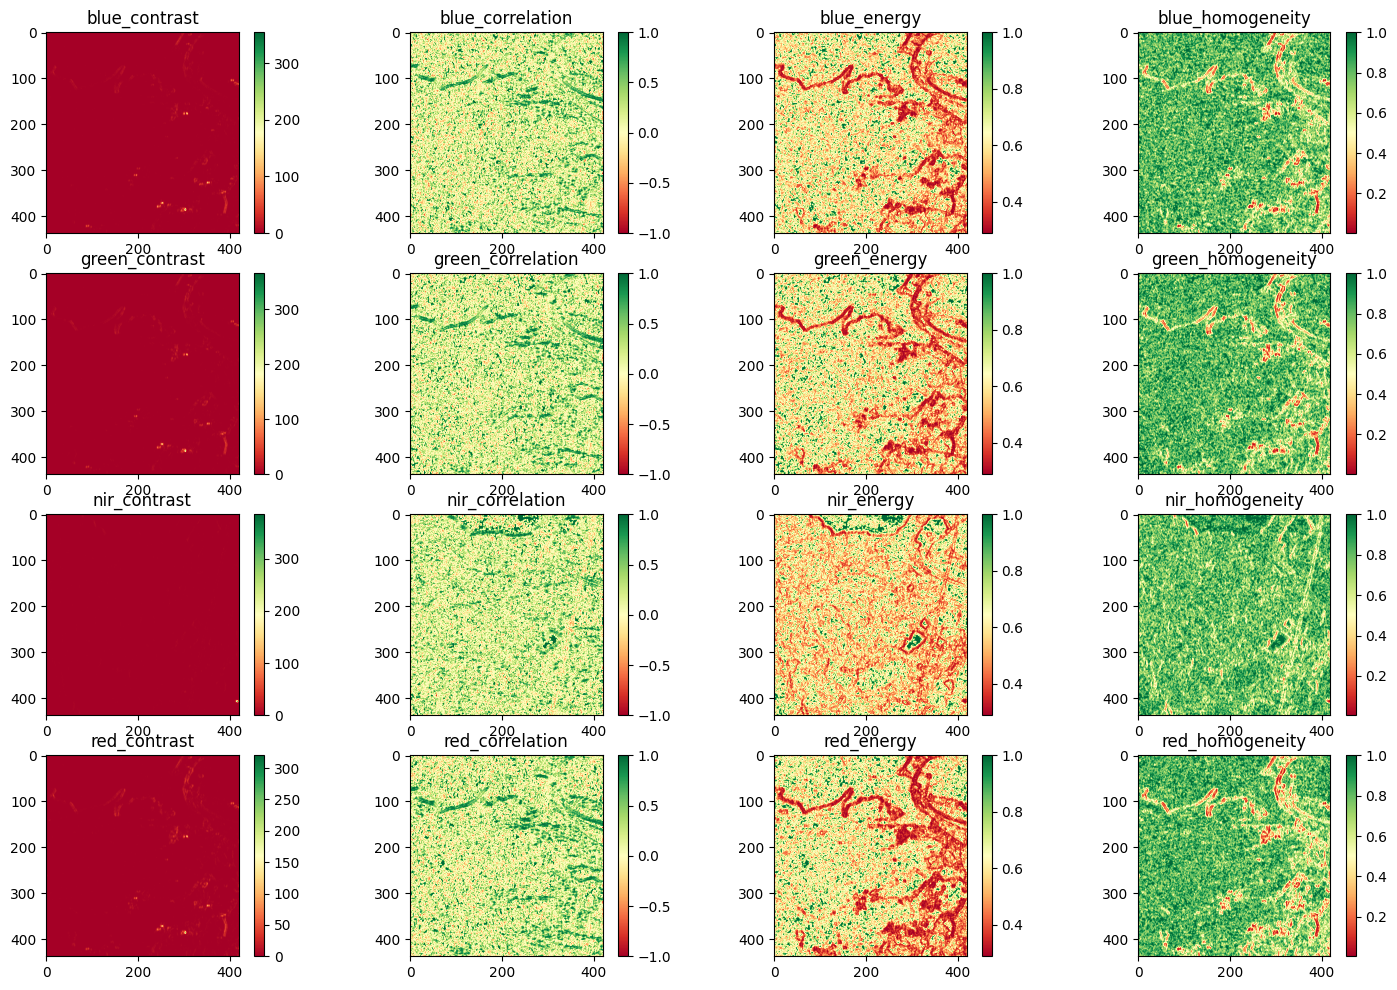

In [48]:
# 创建一个包含4行4列的子图网格
fig, axs = plt.subplots(4, 4, figsize=(18, 12))
i=0
for file in files:
  temp=axs[int(i/4), i%4].imshow(vars()[file[12:-4]], cmap='RdYlGn')
  axs[int(i/4), i%4].set_title(file[12:-4])
  plt.colorbar(temp, ax=axs[int(i/4), i%4])
  i=i+1

In [49]:
def pro(band):
  return band[:200,:200].flatten()
  #return band.flatten()

In [50]:
# 合并为一个特征向量
feature_band = np.column_stack((pro(red_band), pro(green_band), pro(blue_band), pro(nir_band)))
feature_index = np.column_stack((pro(ndvi),pro(rvi),pro(dvi),pro(exg),pro(vdvi),pro(ngbdi),pro(ngrdi)))
feature_text = np.column_stack((pro(blue_contrast),pro(blue_correlation),pro(blue_energy),
pro(green_contrast),
pro(blue_homogeneity),
pro(green_correlation),
pro(green_energy),
pro(green_homogeneity),
pro(nir_contrast),
pro(nir_energy),
pro(nir_correlation),
pro(nir_homogeneity),
pro(red_contrast),
pro(red_energy),
pro(red_correlation),
pro(red_homogeneity)))
features=np.concatenate((feature_band,feature_index,feature_text),axis=1)
#features=feature_band
labels = pro(flag_band)
print('feature共计'+str(features.shape[1])+'维')

feature共计27维


In [51]:
df_features = pd.DataFrame(features,columns=['red_band', 'green_band', 'blue_band', 'nir_band', 'ndvi', 'rvi', 'dvi', 'exg', 'vdvi',
                           'ngbdi', 'ngrdi', 'blue_contrast', 'blue_correlation', 'blue_energy', 'green_contrast',
                           'blue_homogeneity', 'green_correlation', 'green_energy', 'green_homogeneity',
                           'nir_contrast', 'nir_energy', 'nir_correlation', 'nir_homogeneity', 'red_contrast',
                           'red_energy', 'red_correlation', 'red_homogeneity'])
df_features.corr()

,red_band,green_band,blue_band,nir_band,ndvi,rvi,dvi,exg,vdvi,ngbdi,...,green_energy,green_homogeneity,nir_contrast,nir_energy,nir_correlation,nir_homogeneity,red_contrast,red_energy,red_correlation,red_homogeneity
red_band,1.000000,0.913849,0.905443,-0.101499,-0.496234,-0.573917,-0.520212,-0.458850,-0.616510,-0.255294,...,-0.349482,-0.517717,-0.035603,0.036478,0.001213,0.039751,0.591900,-0.395637,0.144892,-0.547097
green_band,0.913849,1.000000,0.873235,0.023071,-0.394730,-0.422881,-0.375962,-0.327835,-0.320342,-0.048968,...,-0.318282,-0.478796,-0.014670,0.024216,-0.008144,0.021256,0.547902,-0.354996,0.119377,-0.502625
blue_band,0.905443,0.873235,1.000000,-0.282152,-0.638647,-0.632501,-0.634347,-0.609577,-0.675641,-0.521906,...,-0.287312,-0.451160,-0.035368,0.075574,0.007790,0.057164,0.526184,-0.323948,0.114818,-0.470785
nir_band,-0.101499,0.023071,-0.282152,1.000000,0.867999,0.822807,0.902428,0.928125,0.519290,0.605032,...,-0.033723,-0.030987,0.075384,-0.180449,-0.070907,-0.132929,0.041055,-0.047457,0.000657,-0.043639
ndvi,-0.496234,-0.394730,-0.638647,0.867999,1.000000,0.927038,0.960060,0.961506,0.672860,0.610241,...,0.093559,0.165724,0.100909,-0.200235,-0.047664,-0.151099,-0.191290,0.120210,-0.048368,0.179779
rvi,-0.573917,-0.422881,-0.632501,0.822807,0.927038,1.000000,0.954906,0.938495,0.745586,0.568916,...,0.162050,0.226606,0.073343,-0.153668,-0.064457,-0.123742,-0.237084,0.185343,-0.086336,0.242076
dvi,-0.520212,-0.375962,-0.634347,0.902428,0.960060,0.954906,1.000000,0.995486,0.712793,0.629964,...,0.122403,0.197610,0.080134,-0.170708,-0.061397,-0.131331,-0.221094,0.130601,-0.062186,0.199473
exg,-0.458850,-0.327835,-0.609577,0.928125,0.961506,0.938495,0.995486,1.000000,0.694782,0.663783,...,0.096009,0.162882,0.078434,-0.175642,-0.062419,-0.132431,-0.183176,0.100504,-0.050496,0.161756
vdvi,-0.616510,-0.320342,-0.675641,0.519290,0.672860,0.745586,0.712793,0.694782,1.000000,0.838493,...,0.195330,0.283950,0.059165,-0.094410,-0.031209,-0.082646,-0.314447,0.237769,-0.104144,0.308186
ngbdi,-0.255294,-0.048968,-0.521906,0.605032,0.610241,0.568916,0.629964,0.663783,0.838493,1.000000,...,0.044251,0.094420,0.043206,-0.106593,-0.033097,-0.077063,-0.118355,0.056303,-0.033137,0.095240


In [52]:
df_band = pd.DataFrame(feature_band,columns=['red_band', 'green_band', 'blue_band', 'nir_band'])
df_band.corr()

,red_band,green_band,blue_band,nir_band
red_band,1.000000,0.913849,0.905443,-0.101499
green_band,0.913849,1.000000,0.873235,0.023071
blue_band,0.905443,0.873235,1.000000,-0.282152
nir_band,-0.101499,0.023071,-0.282152,1.000000


In [53]:
df_index = pd.DataFrame(feature_index,columns=['ndvi', 'rvi', 'dvi', 'exg', 'vdvi','ngbdi', 'ngrdi'])
df_index.corr()

,ndvi,rvi,dvi,exg,vdvi,ngbdi,ngrdi
ndvi,1.000000,0.927038,0.960060,0.961506,0.672860,0.610241,0.539393
rvi,0.927038,1.000000,0.954906,0.938495,0.745586,0.568916,0.696895
dvi,0.960060,0.954906,1.000000,0.995486,0.712793,0.629964,0.586017
exg,0.961506,0.938495,0.995486,1.000000,0.694782,0.663783,0.526302
vdvi,0.672860,0.745586,0.712793,0.694782,1.000000,0.838493,0.868359
ngbdi,0.610241,0.568916,0.629964,0.663783,0.838493,1.000000,0.458728
ngrdi,0.539393,0.696895,0.586017,0.526302,0.868359,0.458728,1.000000


In [56]:
feature_band = np.column_stack((pro(red_band),pro(nir_band)))
feature_index = np.column_stack((pro(ndvi),pro(vdvi),pro(ngbdi)))
features=np.concatenate((feature_band,feature_index,feature_text),axis=1)
print('features共计'+str(features.shape[1])+'维')

features共计21维


In [57]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# 计算特征与目标变量之间的互信息
selector = SelectKBest(score_func=mutual_info_regression, k=10)
selector.fit(features, labels)

# 获取选择的特征子集
selected_features = features[:, selector.get_support(indices=True)]
print('features共计'+str(selected_features.shape[1])+'维')

features共计10维


In [61]:
import numpy as np
from sklearn.preprocessing import StandardScaler


# 创建一个StandardScaler对象
scaler = StandardScaler()

# 使用fit_transform对数据进行标准化
standardized_features = scaler.fit_transform(selected_features)

print(standardized_features)

[[-0.86924706  0.72067121  0.90870712 ...  2.06634321  1.75061471
   1.27397143]
 [-0.87618529  0.59115372  0.87583161 ...  2.06634321  1.75061471
   1.27397143]
 [-0.79292652  0.36615253  0.75269377 ...  2.06634321  1.75061471
   1.27397143]
 ...
 [-0.05053582  0.03243227  0.1718229  ...  0.36864019  0.77867106
   0.76079345]
 [-0.03665936  0.21489122  0.24297069 ...  0.42409384 -0.87363316
   0.24761547]
 [-0.00890643  0.42760243  0.31313269 ...  0.42409384 -0.87363316
   0.24761547]]


# SVM

In [64]:
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import confusion_matrix
import numpy as np

# 创建SVM分类器
svm_classifier = SVC(kernel='rbf')

# 创建五折交叉验证对象
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 执行五折交叉验证并计算准确率
accuracies = cross_val_score(svm_classifier, standardized_features, labels, cv=kfold)

# 获取交叉验证中每个样本的预测结果
predicted_labels = cross_val_predict(svm_classifier, standardized_features, labels, cv=kfold)

# 计算混淆矩阵
confusion_mat = confusion_matrix(labels, predicted_labels)

# 输出混淆矩阵
print("混淆矩阵：")
print(confusion_mat)

# 计算最终准确率
final_accuracy = np.mean(accuracies)

# 打印输出最终准确率
print("最终准确率：", final_accuracy)

混淆矩阵：
[[11531  4433]
 [ 2009 22027]]
最终准确率： 0.83895


# 随机森林

In [63]:
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import numpy as np

# 创建随机森林分类器
rf_classifier = RandomForestClassifier()

# 创建五折交叉验证对象
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 执行五折交叉验证并计算准确率
accuracies = cross_val_score(rf_classifier, standardized_features, labels, cv=kfold)

# 获取交叉验证中每个样本的预测结果
#predicted_labels = cross_val_predict(rf_classifier, features, labels, cv=kfold)

# 计算混淆矩阵
#confusion_mat = confusion_matrix(labels, predicted_labels)
#df_confusion = pd.DataFrame(confusion_mat, index=['Negative', 'Positive'], columns=['Predicted Negative', 'Predicted Positive'])
#print("混淆矩阵：")
#print(df_confusion)

# 计算最终准确率
final_accuracy = np.mean(accuracies)

# 打印输出最终准确率
print("最终准确率：", final_accuracy)


最终准确率： 0.8408249999999999


# 决策树

In [22]:
from sklearn.tree import DecisionTreeClassifier

# 创建决策树分类器
dt_classifier = DecisionTreeClassifier()

# 创建五折交叉验证对象
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 执行五折交叉验证并计算准确率
accuracies = cross_val_score(dt_classifier, features, labels, cv=kfold)

# 获取交叉验证中每个样本的预测结果
predicted_labels = cross_val_predict(dt_classifier, features, labels, cv=kfold)

# 计算混淆矩阵
confusion_mat = confusion_matrix(labels, predicted_labels)
df_confusion = pd.DataFrame(confusion_mat, index=['Negative', 'Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("混淆矩阵：")
print(df_confusion)

# 计算最终准确率
final_accuracy = np.mean(accuracies)

# 打印输出最终准确率
print("最终准确率：", final_accuracy)

混淆矩阵：
          Predicted Negative  Predicted Positive
Negative               11749                4331
Positive                4614               19306
最终准确率： 0.7753249999999999


# 逻辑回归

In [24]:
from sklearn.linear_model import LogisticRegression

# 创建逻辑回归分类器并增加最大迭代次数
logistic_regression = LogisticRegression(max_iter=1000)

# 执行五折交叉验证并计算准确率
accuracies = cross_val_score(logistic_regression, features, labels, cv=kfold)

# 获取交叉验证中每个样本的预测结果
predicted_labels = cross_val_predict(logistic_regression, features, labels, cv=kfold)

# 计算混淆矩阵
confusion_mat = confusion_matrix(labels, predicted_labels)
df_confusion = pd.DataFrame(confusion_mat, index=['Negative', 'Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("混淆矩阵：")
print(df_confusion)

# 计算最终准确率
final_accuracy = np.mean(accuracies)

# 打印输出最终准确率
print("最终准确率：", final_accuracy)


混淆矩阵：
          Predicted Negative  Predicted Positive
Negative                9469                6611
Positive                1577               22343
最终准确率： 0.7952999999999999


In [ ]:
import torch.nn.functional as F
import numpy as np
from skimage.feature import graycomatrix, graycoprops

def compute_features(band,level):
    tensor = torch.from_numpy(band)
    # 将张量移动到GPU上（假设您有可用的GPU）
    if torch.cuda.is_available():
        tensor = tensor.cuda()

    # 将张量转换为灰度图像
    gray_image = tensor

    # 获取图像尺寸
    height, width = gray_image.shape

    # 将灰度图像的值缩放到0-(level-1)范围内
    scaled_image = ((gray_image - gray_image.min()) / (gray_image.max() - gray_image.min()) * (level-1)).type(torch.uint8)
    np_image = scaled_image.cpu().numpy()

    # 创建共生矩阵的张量
    glcm_tensor = torch.zeros((height, width, level, level), device=tensor.device)

    # 并行计算共生矩阵
    for i in range(height):
        if i%10==0:
            print(i/height)
        for j in range(width):
            window = np_image[max(0, i-1):min(height, i+2), max(0, j-1):min(width, j+2)]
            glcm = graycomatrix(window, [1], [0], levels=level, symmetric=True, normed=True)
            glcm_tensor[i, j, :, :] = torch.from_numpy(glcm[:, :, 0, 0])

    # 计算能量、相关性、对比度和一致性特征
    energy = graycoprops(glcm_tensor.cpu().numpy(), prop='energy')
    correlation = graycoprops(glcm_tensor.cpu().numpy(), prop='correlation')
    contrast = graycoprops(glcm_tensor.cpu().numpy(), prop='contrast')
    homogeneity = graycoprops(glcm_tensor.cpu().numpy(), prop='homogeneity')

    # 将结果张量移回GPU
    # if torch.cuda.is_available():
    #     energy = torch.from_numpy(energy).to(tensor.device)
    #     correlation = torch.from_numpy(correlation).to(tensor.device)
    #     contrast = torch.from_numpy(contrast).to(tensor.device)
    #     homogeneity = torch.from_numpy(homogeneity).to(tensor.device)

    return [energy, correlation, contrast, homogeneity]